In [1]:
!pip install lifetimes

     |████████████████████████████████| 593kB 2.8MB/s 


In [ ]:
import lifetimes

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('For_Segmentation.csv')
df.head()

,Unnamed: 0,order_id,customer_id,product_id,total_money,product_category_name_english,customer_unique_id,order_status,order_purchase_timestamp,review_score,order_purchase_quarter,min_order_purchase_timestamp,min_order_purchase_quarter,user_type
0,0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,4244733e06e7ecb4970a6e2683c13e61,72.19,cool_stuff,871766c5855e863f6eccc05f988b23cb,delivered,2017-09-13 08:59:02,5,201703,2017-09-13 08:59:02,201703,New
1,1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,e5f2d52b802189ee658865ca93d83a8f,259.83,pet_shop,eb28e67c4c0b83846050ddfb8a35d051,delivered,2017-04-26 10:53:06,4,201702,2017-04-26 10:53:06,201702,New
2,2,c105be01f21c9df6a2579f59b95cbcd9,02288a47f696f3054b9ef1d5f8e73973,d2f5484cbffe4ca766301b21ab9246dd,24.73,computers_accessories,eb28e67c4c0b83846050ddfb8a35d051,delivered,2017-09-18 16:12:04,5,201703,2017-04-26 10:53:06,201702,Existing
3,3,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,c777355d18b72b67abbeef9df44fd0fd,216.87,furniture_decor,3818d81c6709e39d06b2738a8d3a2474,delivered,2018-01-14 14:33:31,5,201801,2018-01-14 14:33:31,201801,New
4,4,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,7634da152a4610f1595efa32f14722fc,25.78,perfumery,af861d436cfc08b2c2ddefd0ba074622,delivered,2018-08-08 10:00:35,4,201803,2018-08-08 10:00:35,201803,New


In [ ]:
df1=pd.read_csv('new.csv')
df1.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,total_money
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,252.25


In [ ]:
df_new=df[['customer_unique_id','order_purchase_timestamp','total_money']]

In [ ]:
df_new['order_purchase_timestamp'] = pd.to_datetime(df_new['order_purchase_timestamp'])
df_new['order_date'] = df_new.order_purchase_timestamp.dt.date
df_new['order_date'] = pd.to_datetime(df_new['order_date'])
df_new=df_new.drop('order_purchase_timestamp',axis=1)

In [ ]:
df_new.head()

,customer_unique_id,total_money,order_date
0,871766c5855e863f6eccc05f988b23cb,72.19,2017-09-13
1,eb28e67c4c0b83846050ddfb8a35d051,259.83,2017-04-26
2,eb28e67c4c0b83846050ddfb8a35d051,24.73,2017-09-18
3,3818d81c6709e39d06b2738a8d3a2474,216.87,2018-01-14
4,af861d436cfc08b2c2ddefd0ba074622,25.78,2018-08-08


In [ ]:
df_new.shape

(100486, 3)

In [ ]:
last_order_date = df_new['order_date'].max()
print(last_order_date)

2018-09-03 00:00:00


In [ ]:
from lifetimes.plotting import *
from lifetimes.utils import *
#Built-in utility functions from lifetimes package to transform the transactional data (one row per purchase) 
#into summary data (a frequency, recency, age and monetary).

lf_tx_data = summary_data_from_transaction_data(df_new, 'customer_unique_id', 'order_date', \
                                                monetary_value_col='total_money', observation_period_end='2018-09-03')
lf_tx_data.reset_index().head()

,customer_unique_id,frequency,recency,T,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


count    93664.000000
mean         0.023851
std          0.176346
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         14.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 97.84 %


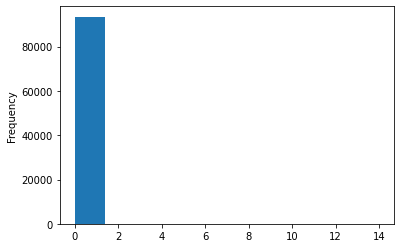

In [ ]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
lf_tx_data['frequency'].plot(kind='hist', bins=10)
print(lf_tx_data['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(lf_tx_data['frequency'] == 0)/float(len(lf_tx_data))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

In [ ]:
#Frequency/Recency Analysis Using the BG/NBD Model
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 93664 subjects, a: 0.10, alpha: 68.09, b: 0.02, r: 0.02>


In [ ]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.015737,0.000797,0.014176,0.017299
alpha,68.091873,6.061031,56.212253,79.971493
a,0.103593,0.018125,0.068068,0.139118
b,0.017375,0.003362,0.010785,0.023965


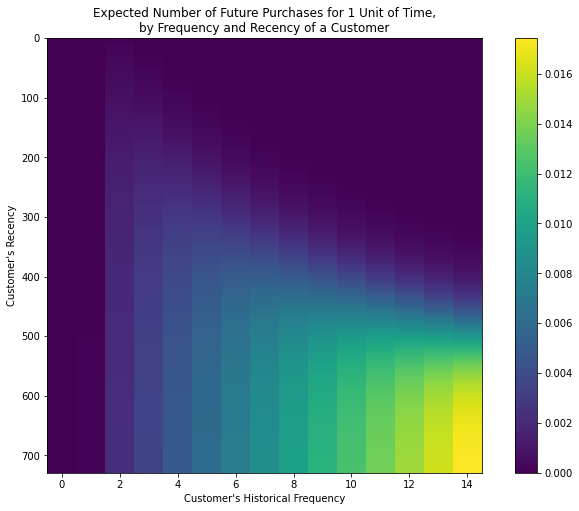

In [ ]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

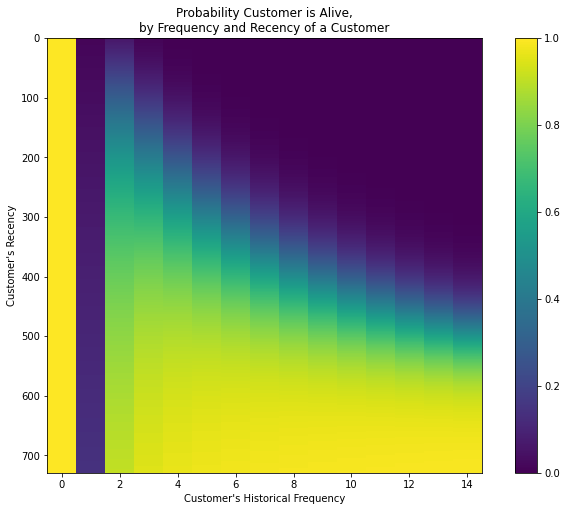

In [ ]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [ ]:
#Predict future transaction in next 10 days i.e.top 10 customers that the model expects them to make purchases 
#in the next 365 days, based on historical data
 
t = 365
lf_tx_data['pred_num_transaction'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, lf_tx_data['frequency'], lf_tx_data['recency'], lf_tx_data['T']),2)
lf_tx_data.sort_values(by='pred_num_transaction', ascending=False).head(10).reset_index()

,customer_unique_id,frequency,recency,T,monetary_value,pred_num_transaction
0,8d50f5eadf50201ccdcedfb9e2ac8455,14.0,462.0,476.0,56.955714,9.02
1,ca77025e7201e3b30c44b472ff346268,6.0,235.0,329.0,138.941667,4.80
2,e0836a97eaae86ac4adc26fbb334a527,2.0,62.0,69.0,32.955000,4.35
3,6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,349.0,133.412000,3.97
4,bc3e7032668d3f411c227eec09221362,2.0,59.0,80.0,72.535000,3.95
5,6a9e15d6fa8ce1cabf193c21aa577f64,2.0,63.0,92.0,148.725000,3.63
6,dc813062e0fc23409cd255f7f53c7074,5.0,418.0,429.0,139.404000,3.45
7,fe81bb32c243a86b2f86fbf053fe6140,4.0,242.0,316.0,381.745000,3.37
8,cfa69922f9968e0e6271647abda09b09,2.0,83.0,114.0,52.880000,3.23
9,34b0cd95480e55c2a701293a2b9671b3,2.0,125.0,131.0,29.825000,3.07


In [ ]:
lf_tx_data.to_csv('CLV_pred.csv')